In [15]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.nonparametric.kernel_regression import KernelReg
from sklearn.model_selection import KFold
from skmisc.loess import loess

In [16]:
# Load the dataset
path = '/Users/sunjiawen/Desktop/Advanced ts/DataPart4.csv'
data4 = pd.read_csv(path)
data4.head()

,Ph,Ti,Te,W
0,1496.970334,20.002530,12.255610,8.678768
1,1411.792178,19.957051,12.298405,7.185271
2,1368.595696,19.904727,12.576470,6.684292
3,1404.547674,19.886161,12.455047,7.702868
4,1376.436161,19.908530,12.638600,7.047383


In [17]:
Phi = data4['Ph'].to_numpy(dtype=float)
Ti  = data4['Ti'].to_numpy(dtype=float)
Te  = data4['Te'].to_numpy(dtype=float)
W   = data4['W'].to_numpy(dtype=float)

In [18]:
# Calculate Ua(W)
Ua = Phi / (Ti - Te)

## LOESS(Using the Package directly)

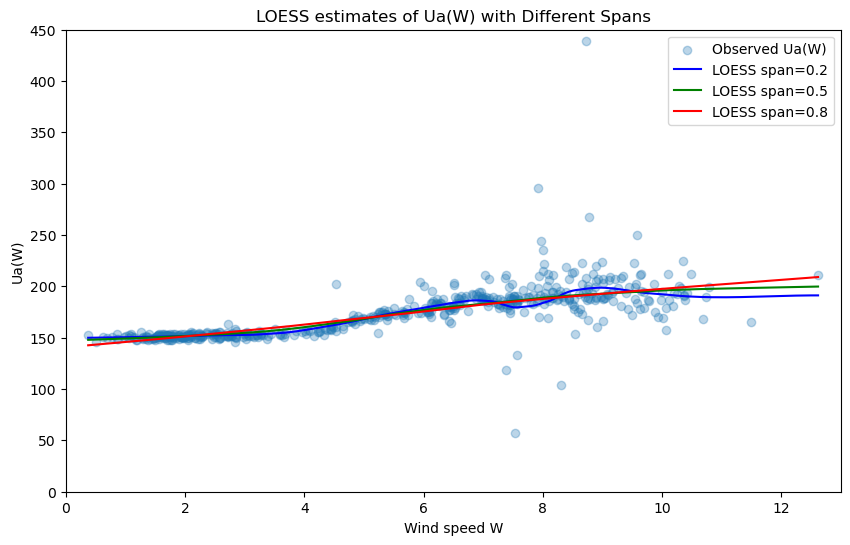

In [19]:
# Define LOESS model and fit
def loess_fit(W, Ua, span, degree=1):
    l = loess(W, Ua, span=span, degree=degree)
    l.fit()
    W_grid = np.linspace(W.min(), W.max(), 200)
    pred = l.predict(W_grid, stderror=True)
    return W_grid, pred.values, pred.stderr

# Different spans for comparison
spans = [0.2, 0.5, 0.8]
colors = ['blue', 'green', 'red']

plt.figure(figsize=(10, 6))
plt.scatter(W, Ua, alpha=0.3, label="Observed Ua(W)")

# linear
for span, color in zip(spans, colors):
    W_grid, Ua_fit, Ua_std = loess_fit(W, Ua, span=span, degree=1)
    plt.plot(W_grid, Ua_fit, color=color, label=f"LOESS span={span}")   


# Plot
plt.title("LOESS estimates of Ua(W) with Different Spans")
plt.xlabel("Wind speed W")
plt.ylabel("Ua(W)")
plt.legend()

# === Zoom out ===
plt.ylim(0, 450)   
plt.xlim(0, 13)    
plt.show()


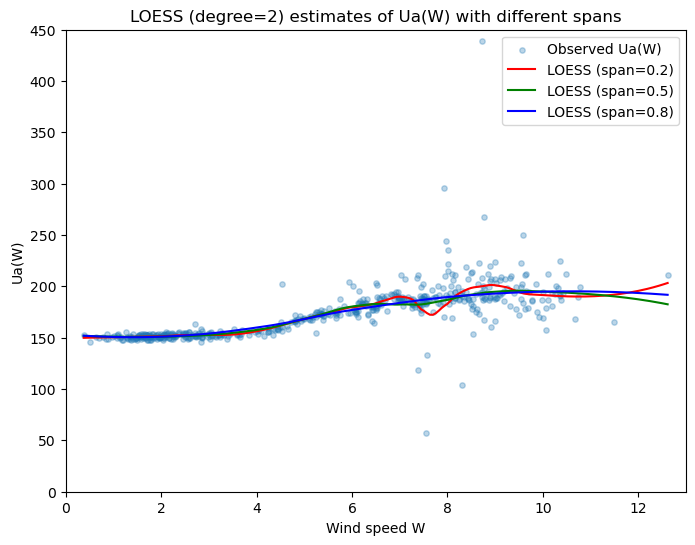

In [20]:
def loess_fit(W, Ua, span):
    l = loess(W, Ua, span=span, degree=2)  # degree=2
    l.fit()
    W_grid = np.linspace(W.min(), W.max(), 200)
    pred = l.predict(W_grid, stderror=True)
    return W_grid, pred.values, pred.stderr

spans = [0.2, 0.5, 0.8]
colors = ['r', 'g', 'b']

plt.figure(figsize=(8,6))
plt.scatter(W, Ua, alpha=0.3, label="Observed Ua(W)", s=15)

for span, color in zip(spans, colors):
    W_grid, Ua_fit, Ua_std = loess_fit(W, Ua, span=span)
    plt.plot(W_grid, Ua_fit, color=color, label=f"LOESS (span={span})")

plt.xlabel("Wind speed W")
plt.ylabel("Ua(W)")
plt.title("LOESS (degree=2) estimates of Ua(W) with different spans")
plt.legend()

# === Zoom out ===
plt.ylim(0, 450)   
plt.xlim(0, 13)    
plt.show()

## Conditional Parametric Model

In [21]:
# conditional parametric regression
X = W
Y = Ua

# Kernel function(Gaussian)
def gaussian_kernel(u, h=1.0):
    return np.exp(-0.5 * (u / h)**2) / (h * np.sqrt(2 * np.pi))

def conditional_parametric(W, Ua_obs, W_grid, h=1.0, degree=1):
    Ua_hat = []
    for w0 in W_grid:
        weights = gaussian_kernel(W - w0, h)
        W_design = np.vstack([W**i for i in range(degree+1)]).T  # [1, W, W^2, ...]
        WTW = W_design.T @ (weights[:, np.newaxis] * W_design)
        WTy = W_design.T @ (weights * Ua_obs)
        beta = np.linalg.solve(WTW + 1e-10 * np.eye(WTW.shape[0]), WTy)  # Regularization
        Ua_hat.append(sum(beta[i] * (w0**i) for i in range(degree+1)))
    return np.array(Ua_hat)

# Generate predictions
X_grid = np.linspace(X.min(), X.max(), 200)
Ua_linear = conditional_parametric(X, Y, X_grid, h=2.0, degree=1)
Ua_quad = conditional_parametric(X, Y, X_grid, h=2.0, degree=2) 

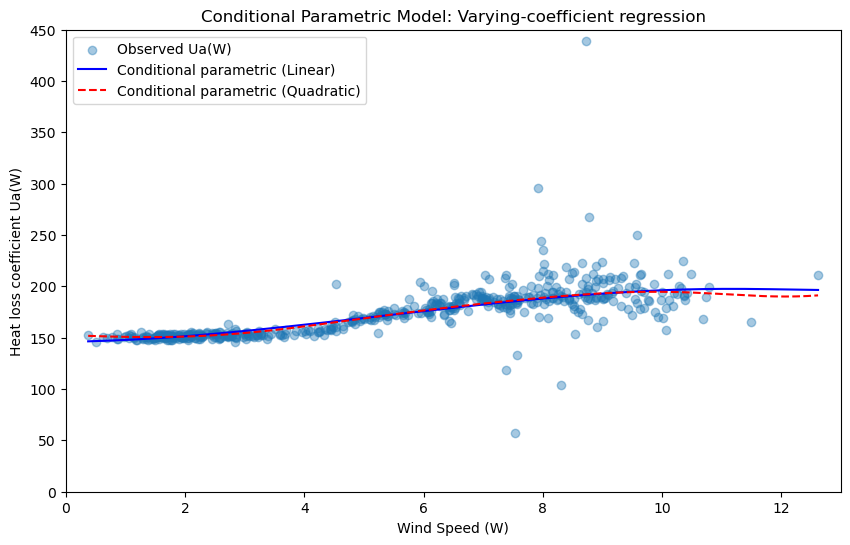

In [22]:
# Visualization
plt.figure(figsize=(10,6))
plt.scatter(X, Y, alpha=0.4, label="Observed Ua(W)")
plt.plot(X_grid, Ua_linear, color='blue', label="Conditional parametric (Linear)")
plt.plot(X_grid, Ua_quad, color='red', linestyle="--", label="Conditional parametric (Quadratic)")
plt.xlabel("Wind Speed (W)")
plt.ylabel("Heat loss coefficient Ua(W)")
plt.title("Conditional Parametric Model: Varying-coefficient regression")
plt.legend()
#plt.grid(True)

# === Zoom out ===
plt.ylim(0, 450)   
plt.xlim(0, 13)    
plt.show()

## Metrics
Now  we tried to validate the models we used that fit the data.

In [48]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skmisc.loess import loess

def evaluate_model(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

def loess_predict(W, Ua, span, degree):
    l = loess(W, Ua, span=span, degree=degree)
    l.fit()
    pred = l.predict(W).values 
    return pred

def conditional_parametric(W, Ua_obs, W_grid, h=1.0, degree=1):
    Ua_hat = []
    for w0 in W_grid:
        weights = np.exp(-0.5*((W - w0)/h)**2) / (h*np.sqrt(2*np.pi))  # Gaussian kernel
        W_design = np.vstack([W**i for i in range(degree+1)]).T
        WTW = W_design.T @ (weights[:, np.newaxis] * W_design)
        WTy = W_design.T @ (weights * Ua_obs)
        beta = np.linalg.solve(WTW + 1e-10*np.eye(WTW.shape[0]), WTy)
        Ua_hat.append(sum(beta[i] * (w0**i) for i in range(degree+1)))
    return np.array(Ua_hat)

# Store results
results = {}

# LOESS deg=1, span=0.5
results["LOESS deg=1 (span=0.5)"] = evaluate_model(Ua, loess_predict(W, Ua, span=0.5, degree=1))

# LOESS deg=2, span=0.5
results["LOESS deg=2 (span=0.5)"] = evaluate_model(Ua, loess_predict(W, Ua, span=0.5, degree=2))

# LOESS deg=1, span=0.2
results["LOESS deg=1 (span=0.2)"] = evaluate_model(Ua, loess_predict(W, Ua, span=0.2, degree=1))

# LOESS deg=2, span=0.2
results["LOESS deg=2 (span=0.2)"] = evaluate_model(Ua, loess_predict(W, Ua, span=0.2, degree=2))

# LOESS deg=1, span=0.8
results["LOESS deg=1 (span=0.8)"] = evaluate_model(Ua, loess_predict(W, Ua, span=0.8, degree=1))

# LOESS deg=2, span=0.8
results["LOESS deg=2 (span=0.8)"] = evaluate_model(Ua, loess_predict(W, Ua, span=0.8, degree=2))


# Conditional parametric linear
Ua_lin_pred = conditional_parametric(W, Ua, W, h=2.0, degree=1)
results["Conditional Linear"] = evaluate_model(Ua, Ua_lin_pred)

# Conditional parametric quadratic
Ua_quad_pred = conditional_parametric(W, Ua, W, h=2.0, degree=2)
results["Conditional Quadratic"] = evaluate_model(Ua, Ua_quad_pred)

results_df = pd.DataFrame(results).T
print(results_df)


                               MSE       MAE        R2
LOESS deg=1 (span=0.5)  852.708283  8.242919  0.261250
LOESS deg=2 (span=0.5)  844.856128  8.128808  0.268052
LOESS deg=1 (span=0.2)  834.606392  8.197524  0.276932
LOESS deg=2 (span=0.2)  829.930436  8.404569  0.280983
LOESS deg=1 (span=0.8)  859.547775  8.853183  0.255324
LOESS deg=2 (span=0.8)  852.646410  8.113168  0.261303
Conditional Linear      856.238426  8.640157  0.258191
Conditional Quadratic   852.070510  8.229816  0.261802


### Model Comparison Summary

- **LOESS performed better** than the conditional parametric models.  
- The best result was **LOESS deg=2 with span=0.2**, giving the lowest **MSE ≈ 829.9** and the highest **R² ≈ 0.28**.  
- A smaller span (0.2) improves the fit but **risks overfitting**, while larger spans (0.8) make the curve smoother but less accurate.  
- **Conditional models (Linear/Quadratic)** had lower performance (**R² around 0.26**), but are simpler and more interpretable.  
